# Correctly Face Masked Recognition (Basic Neural)

In [1]:
# Import necessary libraries.
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [38]:
# Check Tensorflow and Keras version from your system.
print('TensorFlow version is '+tf.__version__)
print('Keras version is '+keras.__version__)

TensorFlow version is 2.8.0
Keras version is 2.8.0


In [2]:
# Check and display the number of images dataset.
image_data_dir = "./images"
image_data_dir = pathlib.Path(image_data_dir)
image_count = len(list(image_data_dir.glob('*/*.jpg'))) + len(list(image_data_dir.glob('*/*.png')))
image_count_correctly_masked = len(list(image_data_dir.glob('Correctly Masked/*.jpg')))
image_count_incorrectly_masked = len(list(image_data_dir.glob('Incorrectly Masked/*.jpg')))
image_count_no_face_detected = len(list(image_data_dir.glob('No Face Detected/*.png')))

print("Total = "+str(image_count))
print("Correctly Masked = "+str(image_count_correctly_masked))
print("Incorrectly Masked = "+str(image_count_incorrectly_masked))
print("No Face Detected = "+str(image_count_no_face_detected))

Total = 1938
Correctly Masked = 950
Incorrectly Masked = 928
No Face Detected = 60


In [3]:
# Define the basic parameter, e.g., Batch Size, Image Size.
batch_size = 10
img_height = 512
img_width = 512

In [4]:
# Define to use 80% of the images for training.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  image_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1938 files belonging to 3 classes.
Using 1551 files for training.


In [5]:
# Define to use 20% of the images for validation.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  image_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1938 files belonging to 3 classes.
Using 387 files for validation.


In [6]:
# Display the name of classes.
class_names = train_ds.class_names
print(class_names)

['Correctly Masked', 'Incorrectly Masked', 'No Face Detected']


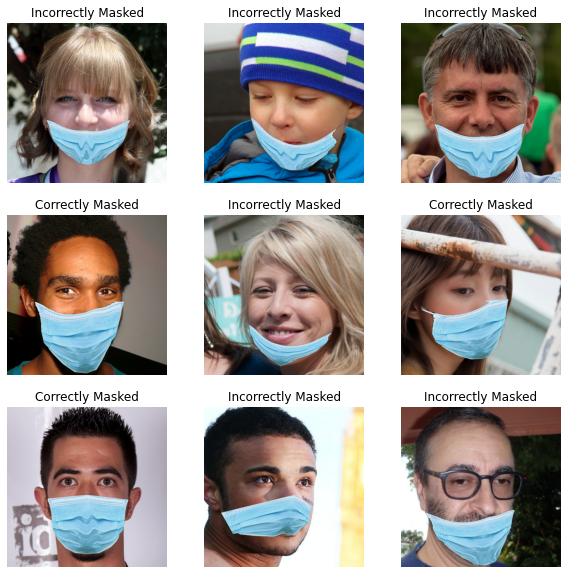

In [8]:
# Display some sample images from the training images dataset.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The image_batch is a tensor of the shape (10, 512, 512, 3). This is a batch of 10 images of shape 512x512x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (10,), these are corresponding labels to the 10 images.

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 512, 512, 3)
(10,)


**Configure the dataset for performance**
* Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

* Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.046078432 1.0


In [11]:
# Create the model.
num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
# Compile the model.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# Display the model summary.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      1

In [14]:
# Start model training.
epochs=3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
156/156 [==============================] - 276s 2s/step - loss: 0.6853 - accuracy: 0.7834 - val_loss: 0.1088 - val_accuracy: 0.9638
Epoch 2/3
156/156 [==============================] - 288s 2s/step - loss: 0.0824 - accuracy: 0.9729 - val_loss: 0.0545 - val_accuracy: 0.9819
Epoch 3/3
156/156 [==============================] - 358s 2s/step - loss: 0.0302 - accuracy: 0.9923 - val_loss: 0.0324 - val_accuracy: 0.9871


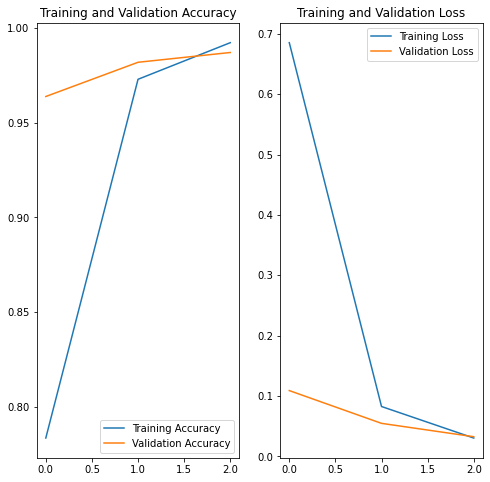

In [15]:
# Display the model training result.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
# Create the model with Dropout.
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [19]:
# Compile the model with Dropout.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
# Display the model with Dropout.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 256, 256, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)     

In [21]:
# Start model training with Dropout.
epochs = 3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
156/156 [==============================] - 353s 2s/step - loss: 1.3745 - accuracy: 0.7614 - val_loss: 0.1945 - val_accuracy: 0.9302
Epoch 2/3
156/156 [==============================] - 334s 2s/step - loss: 0.1255 - accuracy: 0.9549 - val_loss: 0.0809 - val_accuracy: 0.9767
Epoch 3/3
156/156 [==============================] - 328s 2s/step - loss: 0.0538 - accuracy: 0.9800 - val_loss: 0.0801 - val_accuracy: 0.9664


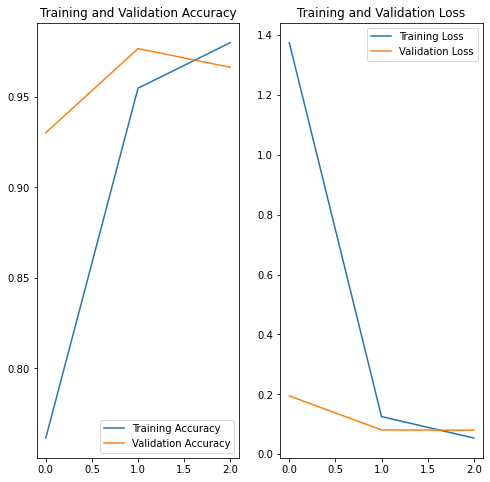

In [22]:
# Display the model training result with Dropout.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# Save the trained model.
model.save('models/basic_neural')

INFO:tensorflow:Assets written to: models/basic_neural\assets


In [25]:
# Reload the trained model.
model = tf.keras.models.load_model('models/basic_neural')
class_names = ['Correctly Masked', 'Incorrectly Masked', 'No Face Detected']
img_height = 512
img_width = 512

**Test with Correctly Masked sample image**

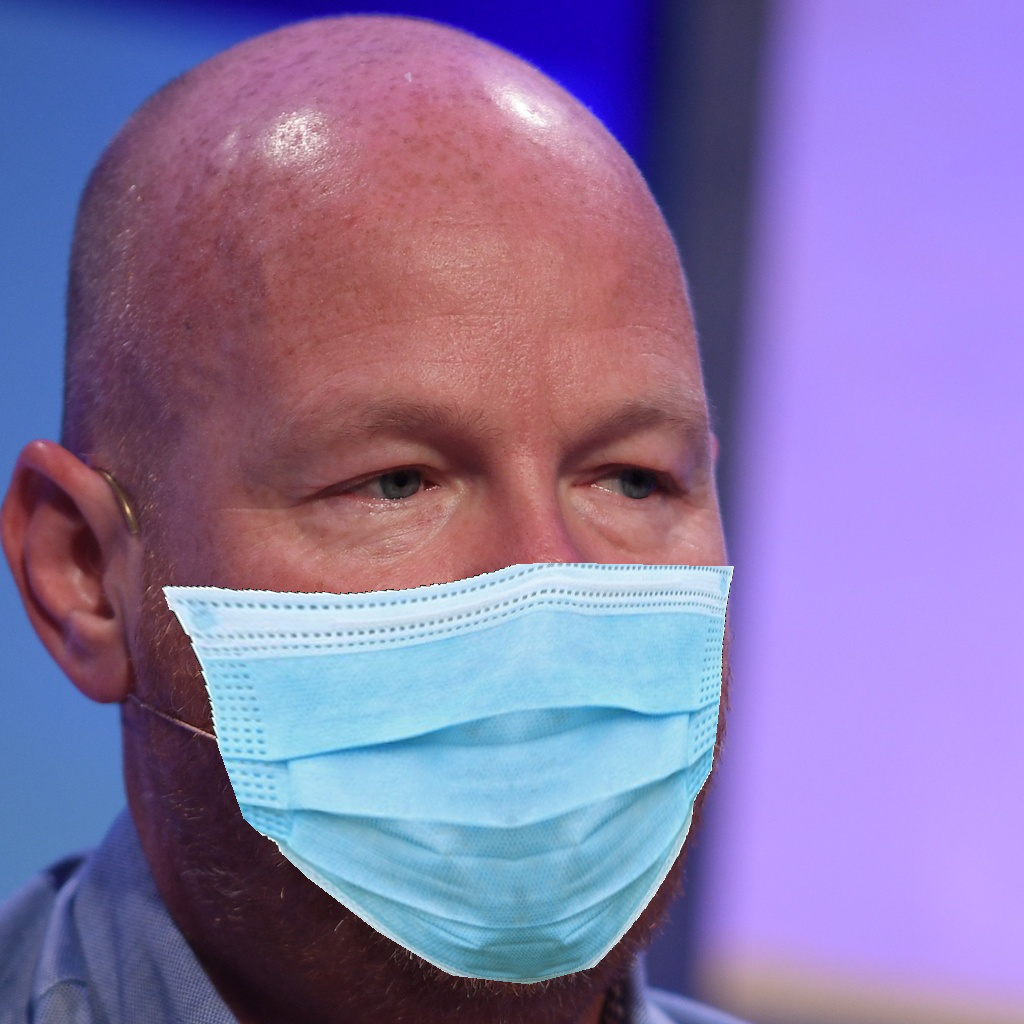

In [33]:
test_correctly_masked = "./test_images/Correctly Masked/01003_Mask.jpg"
PIL.Image.open(test_correctly_masked)

In [26]:
test_file_path = "./test_images"
test_file_path = pathlib.Path(test_file_path)
thumb_test_file_path = "./test_images/Correctly Masked/01003_Mask.jpg"

img = keras.preprocessing.image.load_img(
    thumb_test_file_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Correctly Masked with a 99.83 percent confidence.


**Test with Incorrectly Masked sample image**

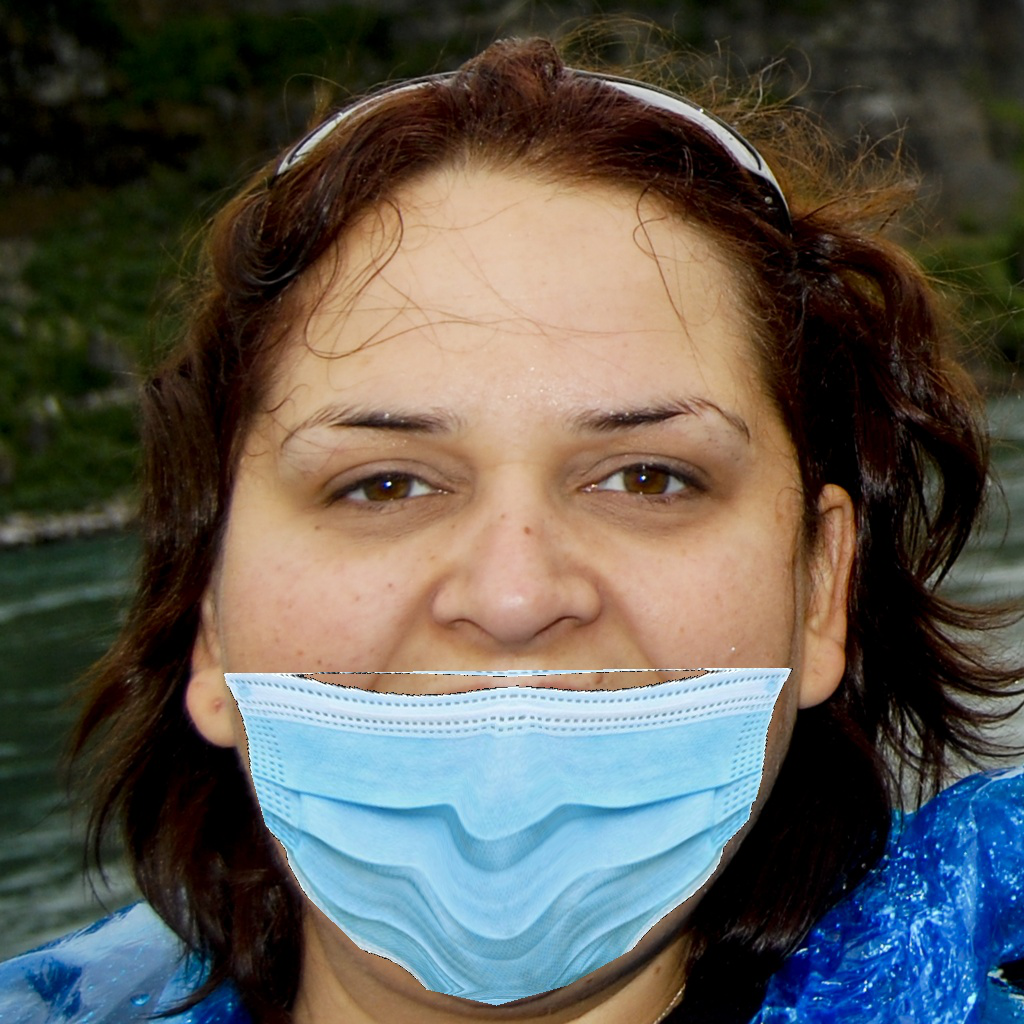

In [34]:
test_correctly_masked = "./test_images/Incorrectly Masked/01004_Mask_Mouth_Chin.jpg"
PIL.Image.open(test_correctly_masked)

In [28]:
test_file_path = "./test_images"
test_file_path = pathlib.Path(test_file_path)
thumb_test_file_path = "./test_images/Incorrectly Masked/01004_Mask_Mouth_Chin.jpg"

img = keras.preprocessing.image.load_img(
    thumb_test_file_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Incorrectly Masked with a 99.99 percent confidence.


**Test with No Face Detected sample image**

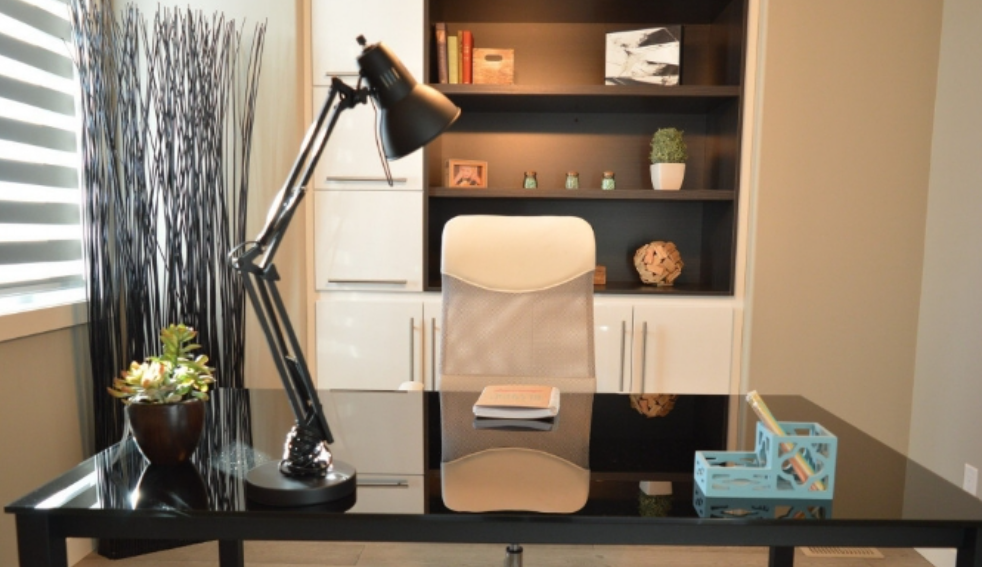

In [35]:
test_correctly_masked = "./test_images/No Face Detected/test-no-face-1.png"
PIL.Image.open(test_correctly_masked)

In [30]:
test_file_path = "./test_images"
test_file_path = pathlib.Path(test_file_path)
thumb_test_file_path = "./test_images/No Face Detected/test-no-face-1.png"

img = keras.preprocessing.image.load_img(
    thumb_test_file_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to No Face Detected with a 88.82 percent confidence.
